# AAE from mass absorption cross section (employ AE33 numerical correction)

In [15]:
#dataframe, plotting, and statistical libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [45]:
plt.style.use('mpl_config.mplstyle')

In [10]:
from rx_burn_datetime_index_config import *

## Import aligned AE33 data

In [11]:
folder = '/Users/jdabutler/Documents/+github/rx burn/aligned CSV'
AE33hz = pd.read_csv(folder + '/ground_AE33_1Hz_align.csv')
AE33hz.datetime = pd.to_datetime(AE33hz.datetime)
AE33hz.set_index('datetime',inplace=True)

## Import 1 Hz MCE data from gas and BC dataframe

In [12]:
df = pd.read_csv(folder+'/aligned_1Hz_gas&BC_06-08-2022.csv')

df.datetime = pd.to_datetime(df.datetime)

MCE = df[['datetime','CO_e','CO2H_e']].set_index('datetime')

Min = df.set_index('datetime').resample('1T').mean()
Min.ATN = df[['datetime','ATN']].set_index('datetime').resample('1T').max()
MCE

CO_e  CO2H_e
datetime                         
2021-04-20 11:58:01   NaN     NaN
2021-04-20 11:58:02   NaN     NaN
2021-04-20 11:58:09   NaN     NaN
2021-04-20 11:58:10   NaN     NaN
2021-04-20 11:58:11   NaN     NaN
...                   ...     ...
2021-04-24 06:27:28  0.02    25.0
2021-04-24 06:27:31  0.02    25.0
2021-04-24 06:27:33  0.02    24.0
2021-04-24 06:27:36  0.02    24.0
2021-04-24 06:28:08  0.03    28.0

[167528 rows x 2 columns]

## Import corrected AAEs from Butler & Kirchstetter correction

In [13]:
dfAAE = pd.read_csv('/Users/jdabutler/Documents/_gs/Blodgett Forest prescribed burn/AAE datasets/correctedAAE.csv')
dfAAE.rename({'Unnamed: 0':'datetime'},axis=1,inplace=True)
dfAAE.set_index('datetime',inplace=True)
dfAAE.head()

AAEcn   AAE_swN  AAE_swN_l  AAE_swN_u
datetime                                                     
2021-04-20 12:03:59  1.828302  1.997097   1.797685   2.196510
2021-04-20 12:07:31  2.696586  3.087834   2.547090   3.628577
2021-04-20 12:38:34  2.152941  2.357047   1.840137   2.873957
2021-04-20 12:41:46  2.622797  2.634944   2.053334   3.216554
2021-04-20 12:45:35  2.802287  2.801097   2.121758   3.480435

## Calculate MCE

In [16]:
mask = ~np.isnan(MCE.CO_e) & ~np.isnan(MCE.CO2H_e) & (MCE.CO_e > 0) & (MCE.CO2H_e > 0)
MCE = MCE[mask]

MCE_min = MCE.resample('1T').apply(np.trapz)
MCE_min['MCE'] = MCE_min.CO2H_e / (MCE_min.CO2H_e+MCE_min.CO_e)

## Functions

In [17]:
def OLSLinRegAAE(X,Y):
    #mask = ~np.isnan(X) & ~np.isnan(Y)
    X = sm.add_constant(X)
    #X = X[mask]
    #Y = Y[mask]
    model = sm.OLS(Y,X)
    r = model.fit()
    
    m = r.params[1]
    b = r.params[0]
    r2 = r.rsquared
    mu = r.conf_int().values[1,0]
    ml = r.conf_int().values[1,1]
    AAE = -m
    AAE_u = -mu
    AAE_l = -ml
    
    return AAE

def OLSconstCI(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y) & (X < 5) & (X > 0) & (Y < 5) & (Y > 0)
    X = X[mask]
    Y = Y[mask]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[1]
    b = r.params[0]
    r2 = r.rsquared
    s_u = r.conf_int().values[1,0]
    s_l = r.conf_int().values[1,1]
    b_u = r.conf_int().values[0,0]
    b_l = r.conf_int().values[0,1]
    
    return s,b,r2,s_l,s_u,b_l,b_u

def OLSnoConst(X,Y):
    mask = ~np.isnan(X) & ~np.isnan(Y) & (X < 5) & (X > 0) & (Y < 5) & (Y > 0)
    X = X[mask]
    Y = Y[mask]
    
    model = sm.OLS(Y,X)
    r = model.fit()
    
    s = r.params[0]
    r2 = r.rsquared
    s_u = r.conf_int().values[0,0]
    s_l = r.conf_int().values[0,1]
    
    return s,r2,s_l,s_u

In [28]:
import statsmodels.api as sm

# define linear regression function to calculate AAE
def AAE(b_abs,wl):
    
    log_wl = np.log(wl)
    log_b = np.log(b_abs)
        
    log_wl = sm.add_constant(log_wl)

    model = sm.OLS(log_b,log_wl)
    r = model.fit()
    
    m = r.params[1]
    b = r.params[0]
    r2 = r.rsquared
    mu = r.conf_int().values[1,0]
    ml = r.conf_int().values[1,1]
    AAE = -m
    AAE_u = -mu
    AAE_l = -ml
    
    return AAE

def AAE2(b_abs,wl):
    
    log_wl = np.log(wl)
    log_b = np.log(b_abs)
        
    #log_wl = sm.add_constant(log_wl)

    model = sm.OLS(log_b,log_wl)
    r = model.fit()
    
    #m = r.params[1]
    m = r.params[0]
    # r2 = r.rsquared
    # mu = r.conf_int().values[1,0]
    # ml = r.conf_int().values[1,1]
    AAE = m
    # AAE_u = -mu
    # AAE_l = -ml
    
    return AAE

## Create b_samp and b_samp (minutely) matrices

In [29]:
b = AE33hz[['BC' + str(i) for i in range(1,8)]].copy() #create dataframe of corrected BC values from AE33
b['Status'] = AE33hz['Status']

wl = [370,470,520,590,660,880,950] #wavelengths of AE33
macs = [18.47,14.54,13.14,11.58,10.35,7.77,7.19] #mass absorption cross section
log_wl = np.log(wl)


for i in range(1,8):
    j = i - 1
    b['b_'+str(wl[j])] = b['BC'+str(i)]*macs[j]
    
b_samp = b[b.Status.isin([0,128])]

#calculate the Angstrom Absorption Exponent with 2 point method
b_samp['AAE_470950'] = - np.log(b_samp['b_470']/b_samp['b_950']) / np.log(wl[1]/wl[6])
b_samp['AAE_370950'] = -np.log(b_samp['b_370']/b_samp['b_950']) / np.log(wl[0]/wl[6])

b_samp['AAE_7pt'] = b_samp[['b_' + str(wl[i]) for i in range(7)]].apply(AAE,axis=1,wl=wl)

/Users/jdabutler/opt/anaconda3/envs/blodgett/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jdabutler/opt/anaconda3/envs/blodgett/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_7495/3041756892.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_samp['AAE_470950'] = - np.log(b_samp['b_470']/b_samp['b_950']) / np.log(wl[1]/wl[6])
/Users/jdabutler/opt/anaconda3/envs/blodgett/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by z

In [38]:
b_samp.replace([np.inf, -np.inf], np.nan, inplace=True)

/var/folders/ft/cvp8z_vj1m9gr24vdrsn17rw0000gn/T/ipykernel_7495/895658249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_samp.replace([np.inf, -np.inf], np.nan, inplace=True)


### save 1 Hz AAE dataset

In [33]:
fold = '/Users/jdabutler/Documents/+github/rx burn/AAE datasets/'
today = 'test'

b_samp.to_csv(fold+'AAE_1Hz_' +today +'.csv')

### create minutely AAE dataset 

In [34]:
b_samp1 = b_samp.resample('1T').mean()
dfMin = MCE_min.join(b_samp1[['AAE_470950','AAE_7pt']],on='datetime')
dfMin.drop(dfMin[d1E:d2b].index,inplace=True)
dfMin.drop(dfMin[d2E:d3b].index,inplace=True)
dfMin.drop(dfMin[d3e:d4b1].index,inplace=True)

# Compare different AAE methods

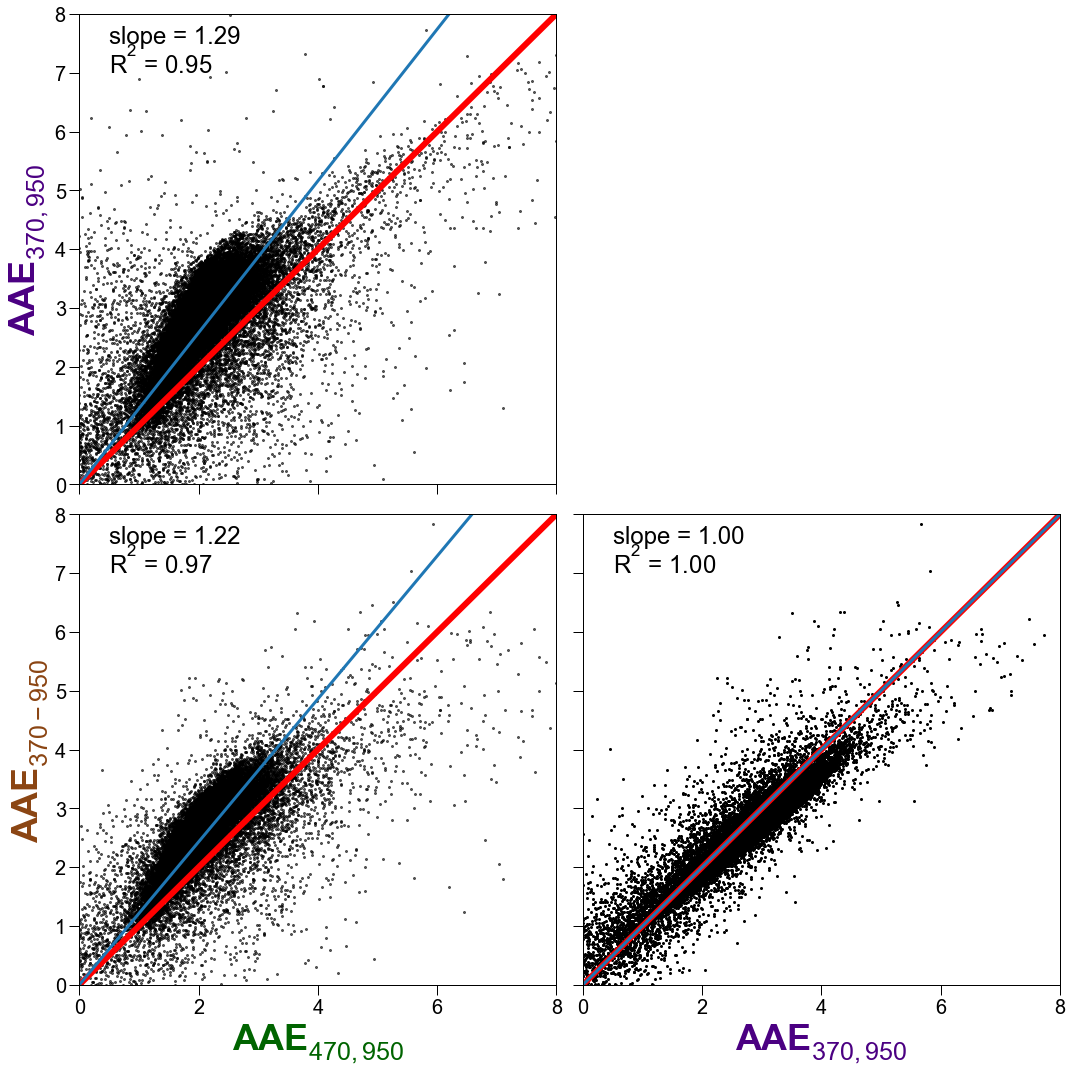

In [40]:
x = np.linspace(0,8)

fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(15,15))

s,r2,s_l,s_u = OLSnoConst(b_samp['AAE_470950'],b_samp['AAE_7pt'])
ax[1,0].plot(b_samp['AAE_470950'],b_samp['AAE_7pt'],'o',ms=2,alpha=0.6,c = 'k')
ax[1,0].plot([0,8],[0,8],'-r',lw=6)
ax[1,0].plot(x,s*x,'-')
#ax[1,0].plot(x,s_l*x,'--')
#ax[1,0].plot(x,s_u*x,'--')
ax[1,0].set_xlim([0,8])
ax[1,0].set_ylim([0,8])
ax[1,0].text(0.5,7.5,'slope = {:.2f}'.format(s),fontsize=24)
ax[1,0].text(0.5,7,'R$^2$ = {:.2f}'.format(r2),fontsize = 24)
ax[1,0].set_xlabel('AAE$_{470,950}$',fontsize=36,fontweight='bold',color='#006400')
ax[1,0].set_ylabel('AAE$_{370-950}$',fontsize=36,fontweight='bold',color='#8B4513')
#---------------------------------------------------------------------
s,r2,s_l,s_u = OLSnoConst(b_samp['AAE_470950'],b_samp['AAE_370950'])
ax[0,0].plot(b_samp['AAE_470950'],b_samp['AAE_370950'],'o',ms=2,alpha=0.6,c='k')
ax[0,0].plot([0,8],[0,8],'-r',lw=6)
ax[0,0].plot(x,s*x,'-')
#ax[0,0].plot(x,s_l*x,'--')
#ax[0,0].plot(x,s_u*x,'--')
ax[0,0].set_ylabel('AAE$_{370,950}$',fontsize=36,fontweight='bold',color='#4B0082')
ax[0,0].text(0.5,7.5,'slope = {:.2f}'.format(s),fontsize=24)
ax[0,0].text(0.5,7,'R$^2$ = {:.2f}'.format(r2),fontsize = 24)
#ax[0,0].set_xlabel('AAE$_{470,950}$',fontsize=36,fontweight='bold')
#---------------------------------------------------------------------
ax[0,1].axis(False)
#---------------------------------------------------------------------
s,r2,s_l,s_u = OLSnoConst(b_samp['AAE_370950'],b_samp['AAE_370950'])
ax[1,1].plot(b_samp['AAE_370950'],b_samp['AAE_7pt'],'o',ms=2,c='k')
ax[1,1].plot([0,8],[0,8],'-r',lw=6)
ax[1,1].set_xlabel('AAE$_{370,950}$',fontsize=36,fontweight='bold',color='#4B0082')
ax[1,1].plot(x,s*x,'-')
ax[1,1].text(0.5,7.5,'slope = {:.2f}'.format(s),fontsize=24)
ax[1,1].text(0.5,7,'R$^2$ = {:.2f}'.format(r2),fontsize = 24)

fig.tight_layout()

## Timeseries of AAE

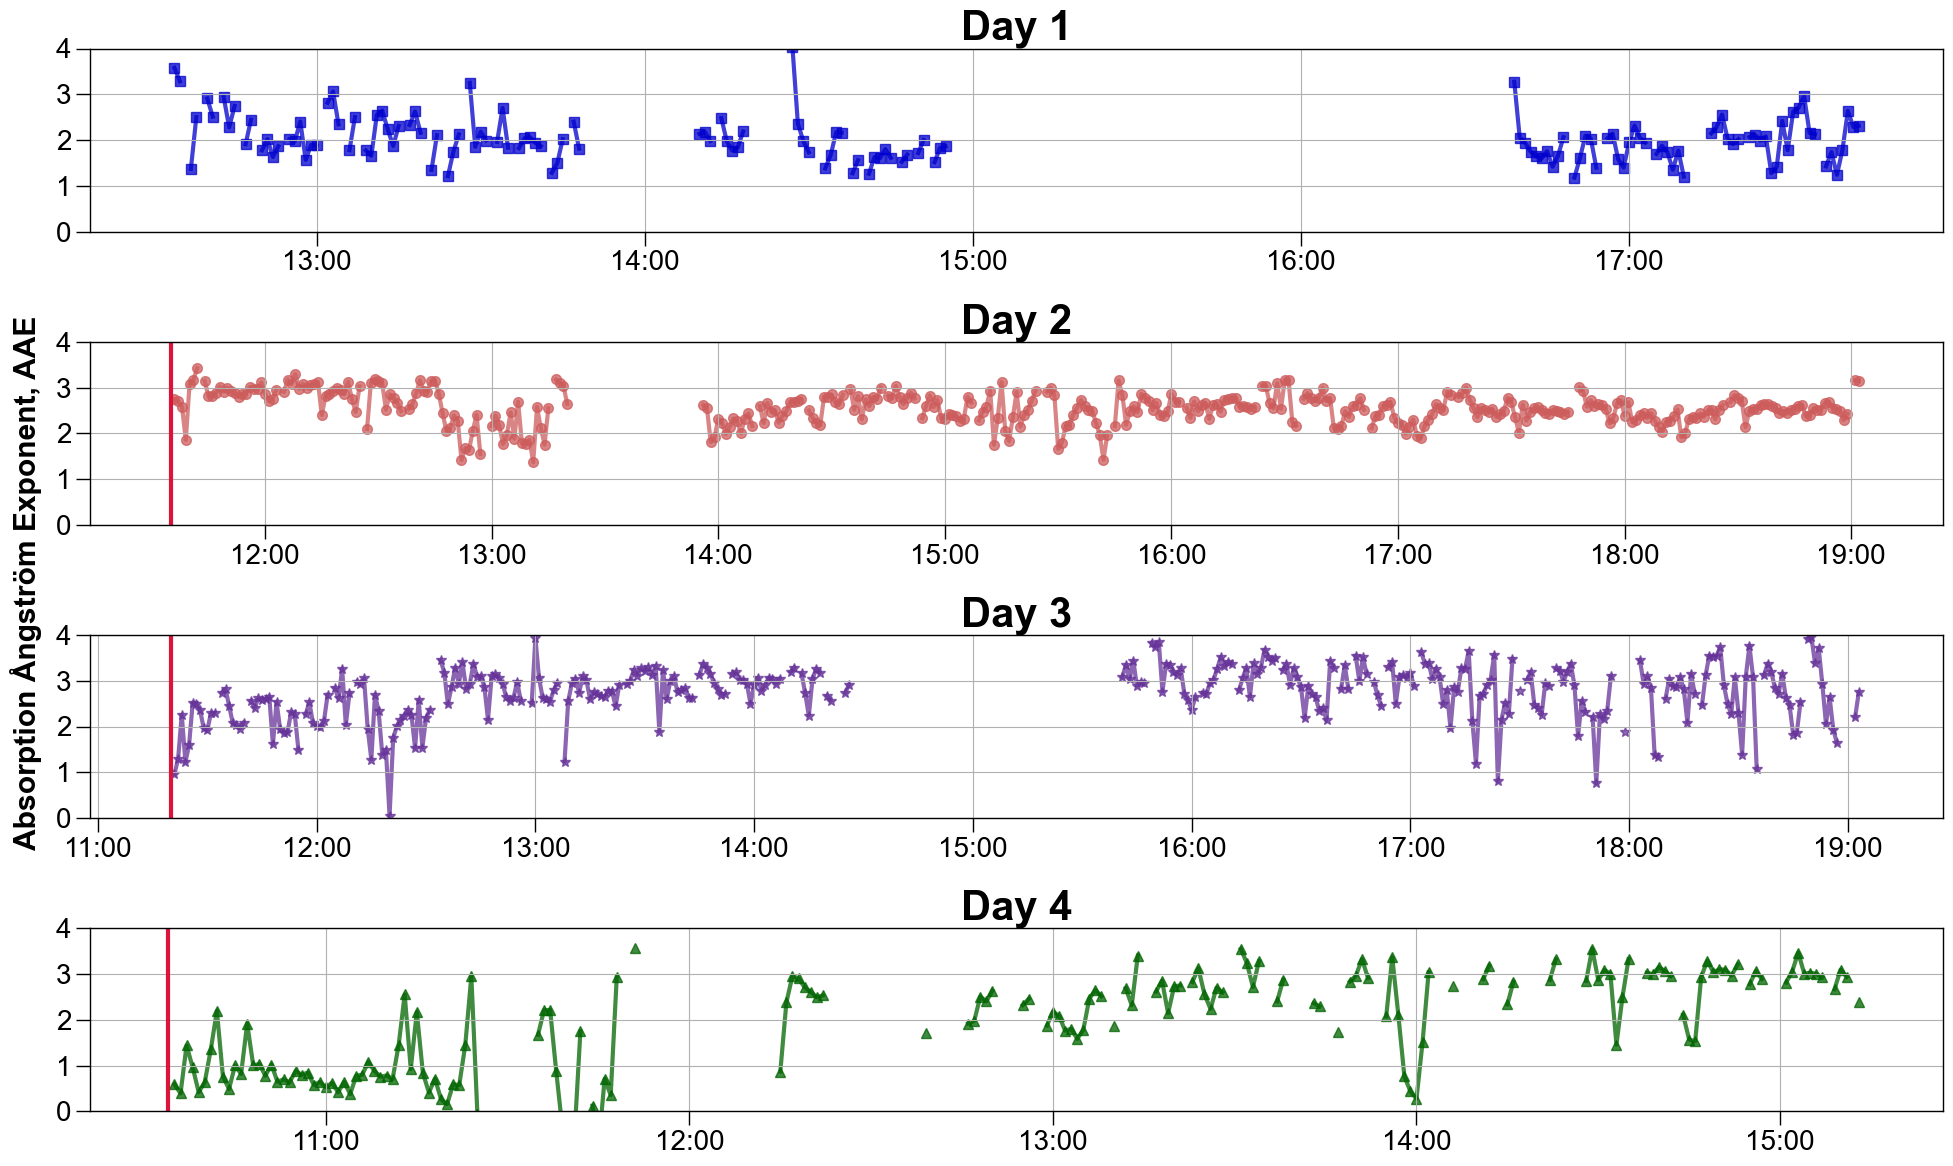

In [47]:
from matplotlib.dates import DateFormatter
timeFormat = DateFormatter('%H:%M')

fig,ax = plt.subplots(4,1,sharey=True)

d1 = dfMin.loc[d1be:d1E]
ax[0].plot(d1.index,d1.AAE_7pt,'s-',color = '#0000CD',ms = 7,zorder = 0,alpha = 0.75,label = 'Day 1')
#ax[0].axvline(d2b,color='#DC143C')

d2 = dfMin.loc[d2S:d2E]
ax[1].plot(d2.index,d2.AAE_7pt,'o-',color = '#CD5C5C',ms = 7,zorder = 0,alpha = 0.75,label = 'Day 2')
ax[1].axvline(d2b,color='#DC143C')

d3 = dfMin.loc[d3S:d3e]
ax[2].plot(d3.index,d3.AAE_7pt,'*-',color = '#663399',ms = 7,zorder = 0,alpha = 0.75,label = 'Day 3')
ax[2].axvline(d3b,color='#DC143C')
fig.supylabel('Absorption Ångström Exponent, AAE',fontweight='bold')

d4 = dfMin.loc[d4c:d4e]
ax[3].plot(d4.index,d4.AAE_7pt,'^-',color = '#006400',ms = 7,zorder = 0,alpha = 0.75,label = 'Day 4')
ax[3].axvline(d4b1,color='#DC143C')

for i in np.arange(4):
    ax[i].grid(True)
    ax[i].set_ylim([0,4])
    ax[i].set_yticks([0,1,2,3,4])
    ax[i].xaxis.set_major_formatter(timeFormat)
    ax[i].set_title('Day '+ str(i+1),fontsize=30,fontweight='bold')    

fig.tight_layout()
#fig.savefig('AAE_ts.png')

## AAE vs MCE

### Linear fit with 95% CI

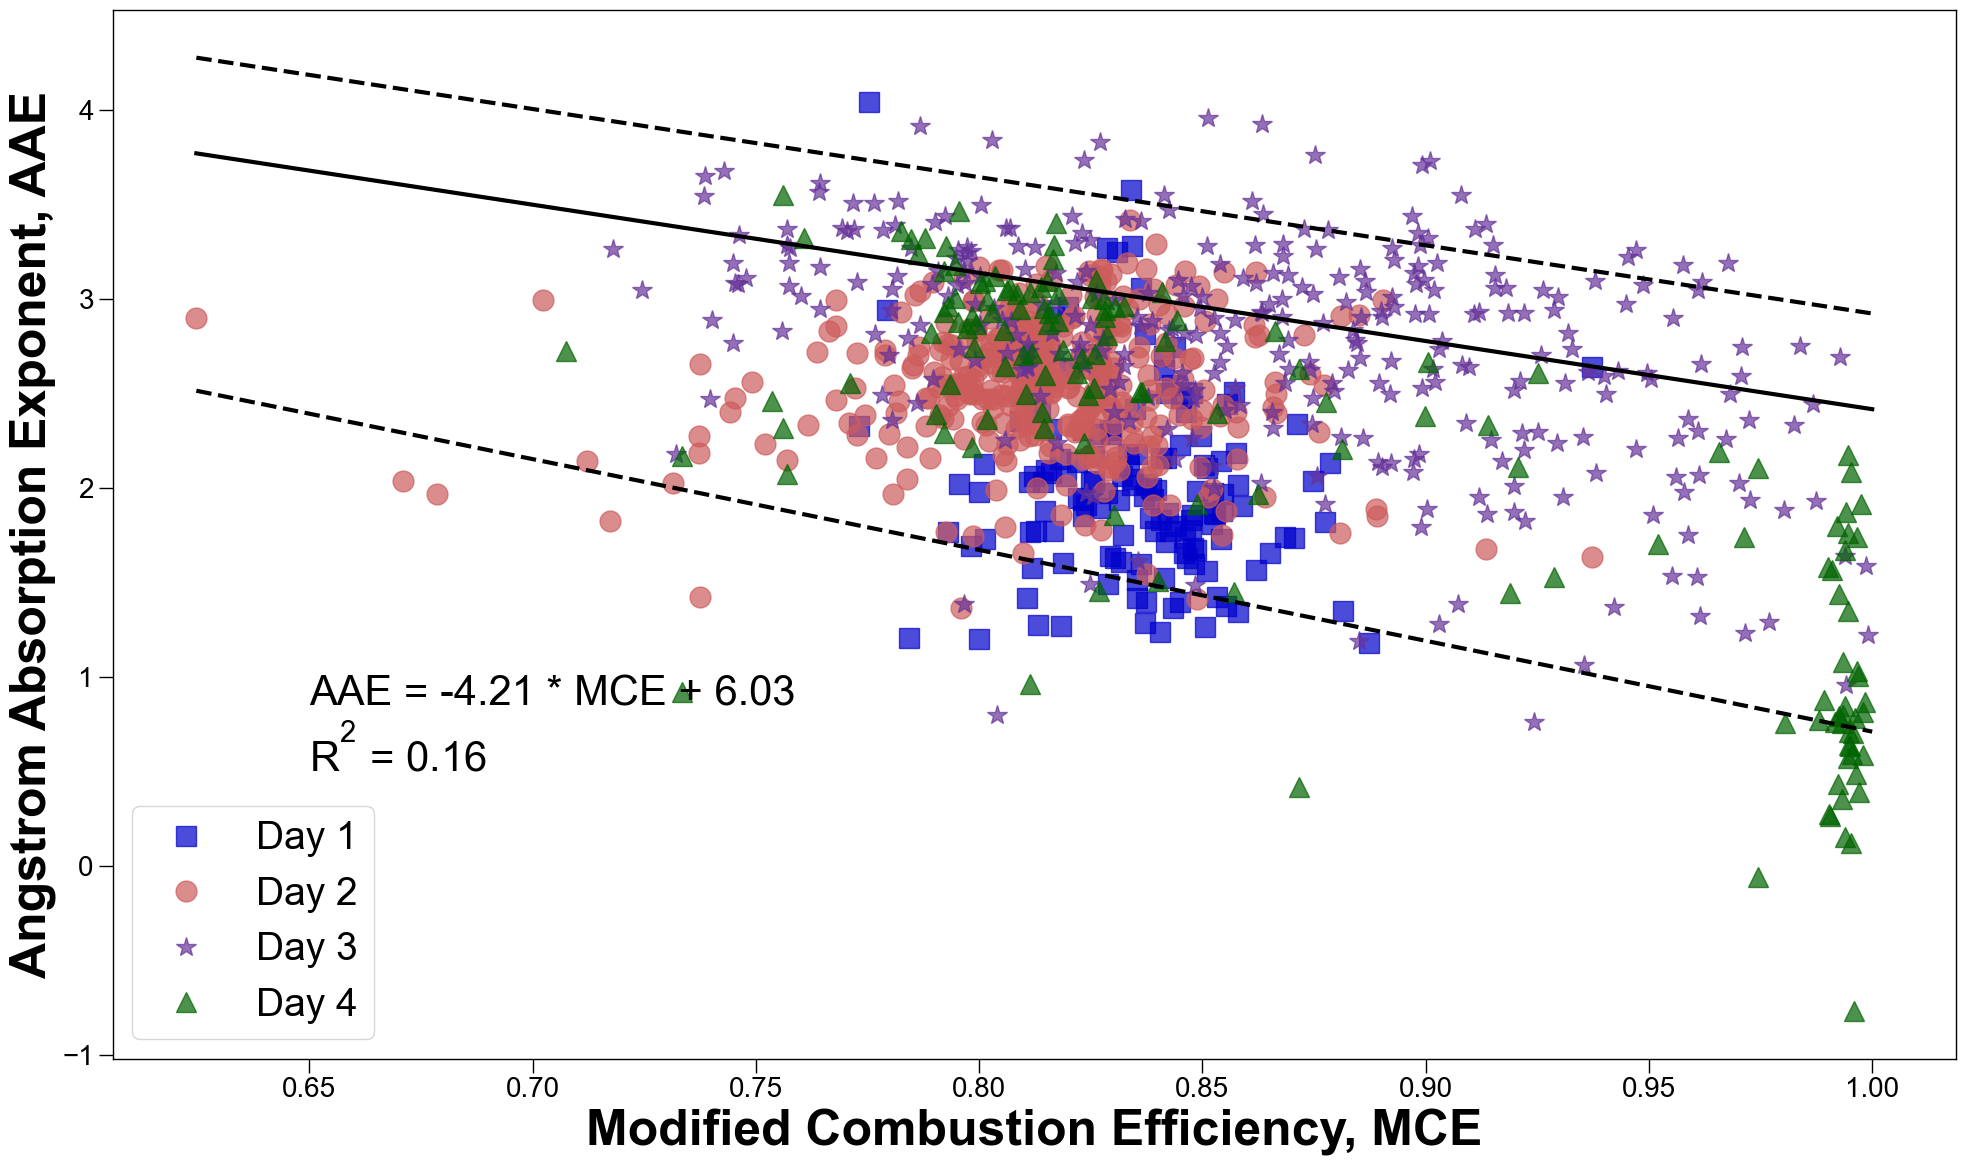

In [48]:
mask = (dfMin.MCE > 0) & (dfMin.MCE < 1)
x = dfMin.MCE[mask]
y = dfMin.AAE_7pt[mask]


s,b,r2,s_l,s_u,b_l,b_u = OLSconstCI(x,y)


fig,ax = plt.subplots()

d1 = dfMin.loc[d1be:d1E]
ax.plot(d1.MCE,d1.AAE_7pt,'s',color = '#0000CD',ms = 15,zorder = 0,alpha = 0.7,label = 'Day 1')
d2 = dfMin.loc[d2S:d2E]
ax.plot(d2.MCE,d2.AAE_7pt,'o',color = '#CD5C5C',ms = 15,zorder = 0,alpha = 0.7,label = 'Day 2')
d3 = dfMin.loc[d3S:d3e]
ax.plot(d3.MCE,d3.AAE_7pt,'*',color = '#663399',ms = 15,zorder = 0,alpha = 0.7,label = 'Day 3')
d4 = dfMin.loc[d4c:d4e]
ax.plot(d4.MCE,d4.AAE_7pt,'^',color = '#006400',ms = 15,zorder = 0,alpha = 0.7,label = 'Day 4')

x = np.linspace(dfMin.MCE.min(),1)

ax.plot(x,x*s_l+b,'-k')
ax.plot(x,x*s_l+b_l,'--k')
ax.plot(x,x*s_u+b_u,'--k')

#ax.plot(MCE_min.MCE,MCE_min.AAE_2pt,'o',alpha=0.8)
#ax.set_xlim([0,1])
#ax.set_ylim([0,4.1])
ax.set_xlabel('Modified Combustion Efficiency, MCE',fontsize=36,fontweight='bold')
ax.set_ylabel('Angstrom Absorption Exponent, AAE',fontsize=36,fontweight='bold')
ax.legend(fontsize=28,loc='lower left')
ax.text(0.65,0.5,'AAE = {:.2f} * MCE + {:.2f}\nR$^2$ = {:.2f}'.format(s,b,r2),fontsize=30)

fig.tight_layout()
fig.savefig('AAE7pt_vs_MCE.png')

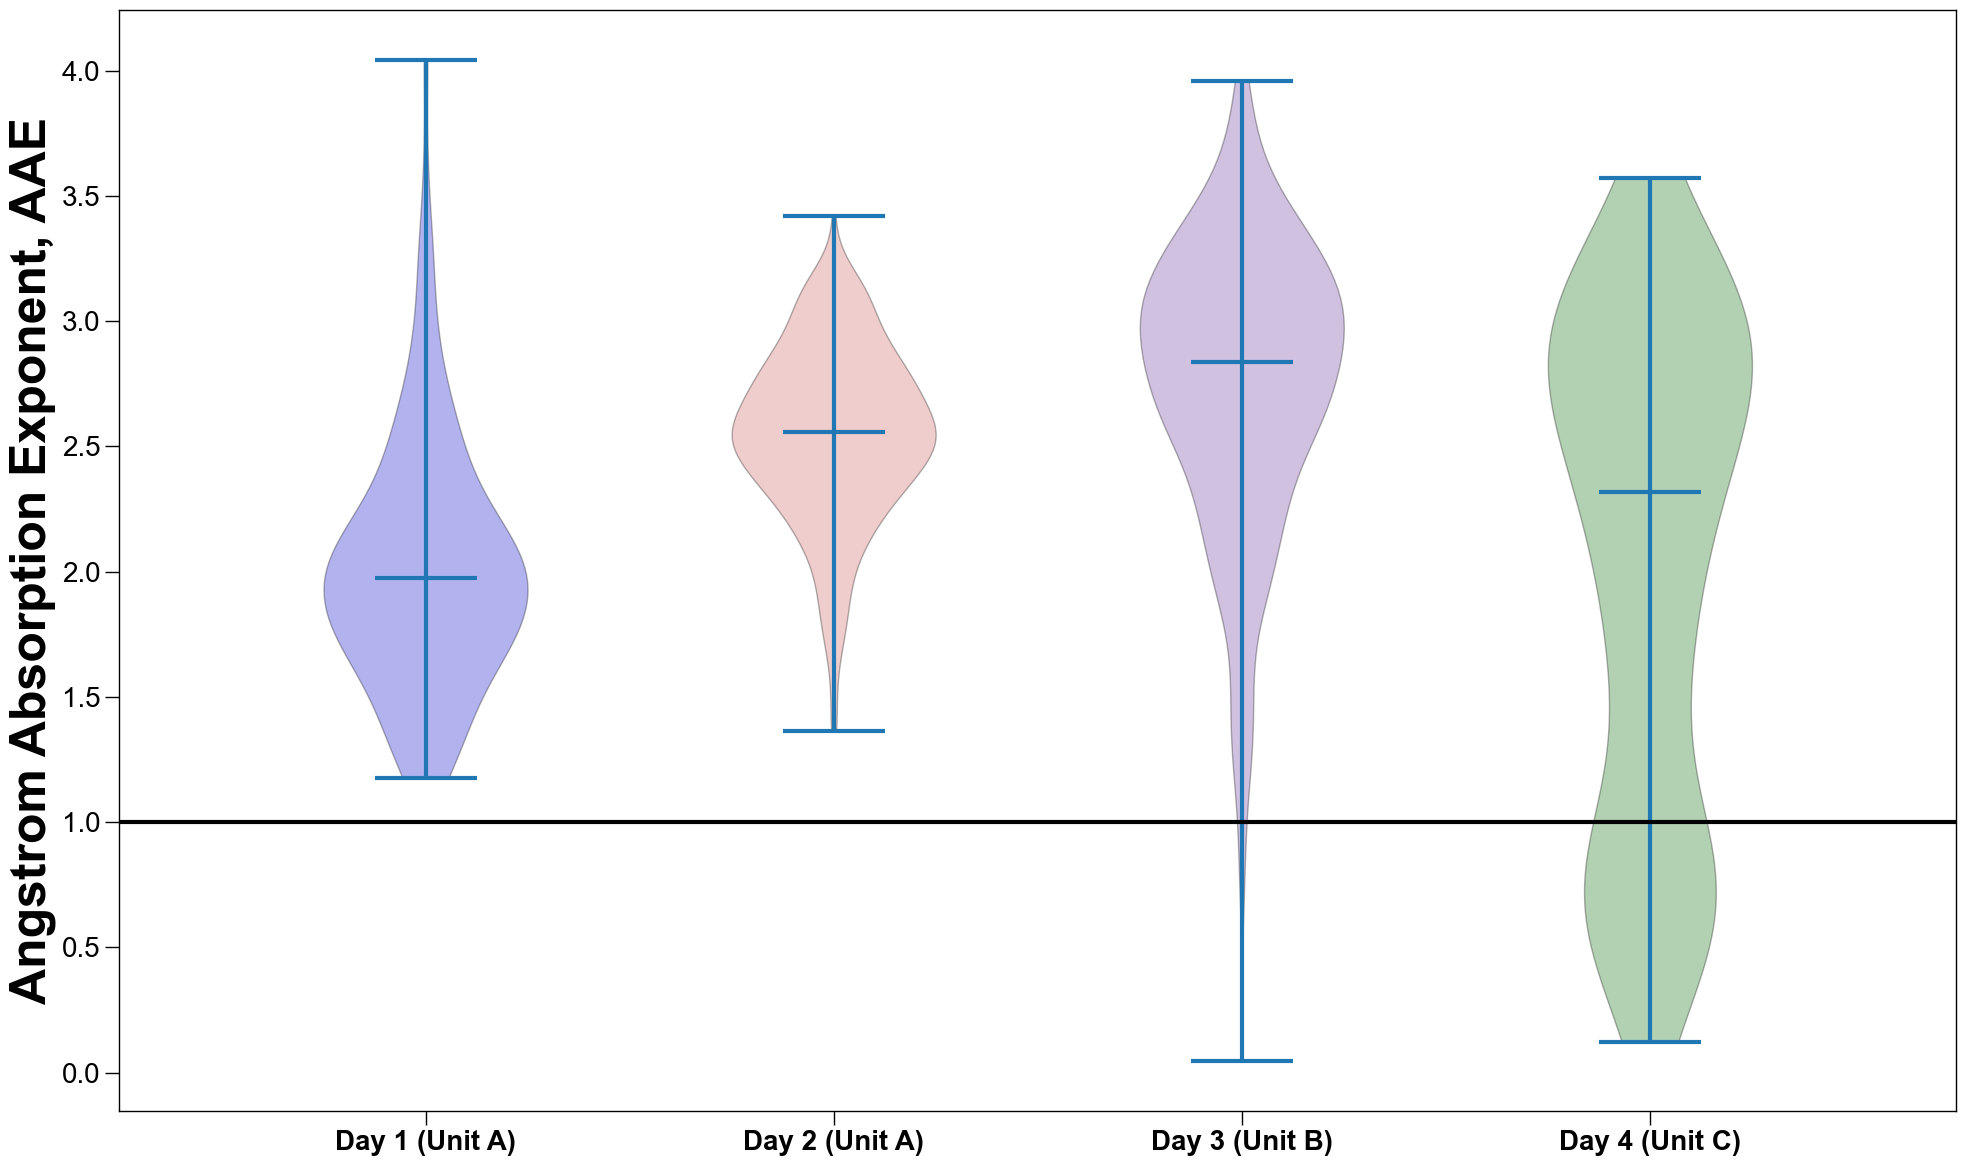

In [49]:
m1 = ~np.isnan(d1.AAE_7pt.values)
m2 = ~np.isnan(d2.AAE_7pt.values)
m3 = ~np.isnan(d3.AAE_7pt.values)
m4 = ~np.isnan(d4.AAE_7pt.values) & (d4.AAE_7pt > 0)

def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontweight='bold')
    ax.set_xlim(0.25, len(labels) + 0.75)

fig,ax = plt.subplots()

v = ax.violinplot([d1.AAE_7pt.values[m1],d2.AAE_7pt.values[m2],d3.AAE_7pt.values[m3],d4.AAE_7pt.values[m4]],showmedians=True)

colors = ['#0000CD','#CD5C5C','#663399','#006400']
labels = ['Day 1 (Unit A)','Day 2 (Unit A)','Day 3 (Unit B)','Day 4 (Unit C)']
for i,c in enumerate(colors):
    v['bodies'][i].set_color(c)
    v['bodies'][i].set_edgecolor('k')

    
ax.axhline(y=1,c='k')
ax.set_ylabel('Angstrom Absorption Exponent, AAE',fontsize=36,fontweight='bold')
set_axis_style(ax,labels)

fig.tight_layout()

fig.savefig('violin_AAE.png')

## Compare B/K corrected to AE33 corrected AAE

In [50]:
times = list(range(0,len(dfAAE.index)))

dfAAE['AAE_7pt'] = np.nan
dfAAE['AAE_2pt'] = np.nan

for t in times:
    if t > 0:
        t1 = dfAAE.index[t-1]
        t2 = dfAAE.index[t]
    else:
        t1 = b_samp.index[0]
        t2 = dfAAE.index[t]
    
    means = b_samp[t1:t2].mean()
    
    dfAAE.loc[t2,'AAE_2pt'] = means.loc['AAE_470950']
    dfAAE.loc[t2,'AAE_7pt'] = means.loc['AAE_7pt']

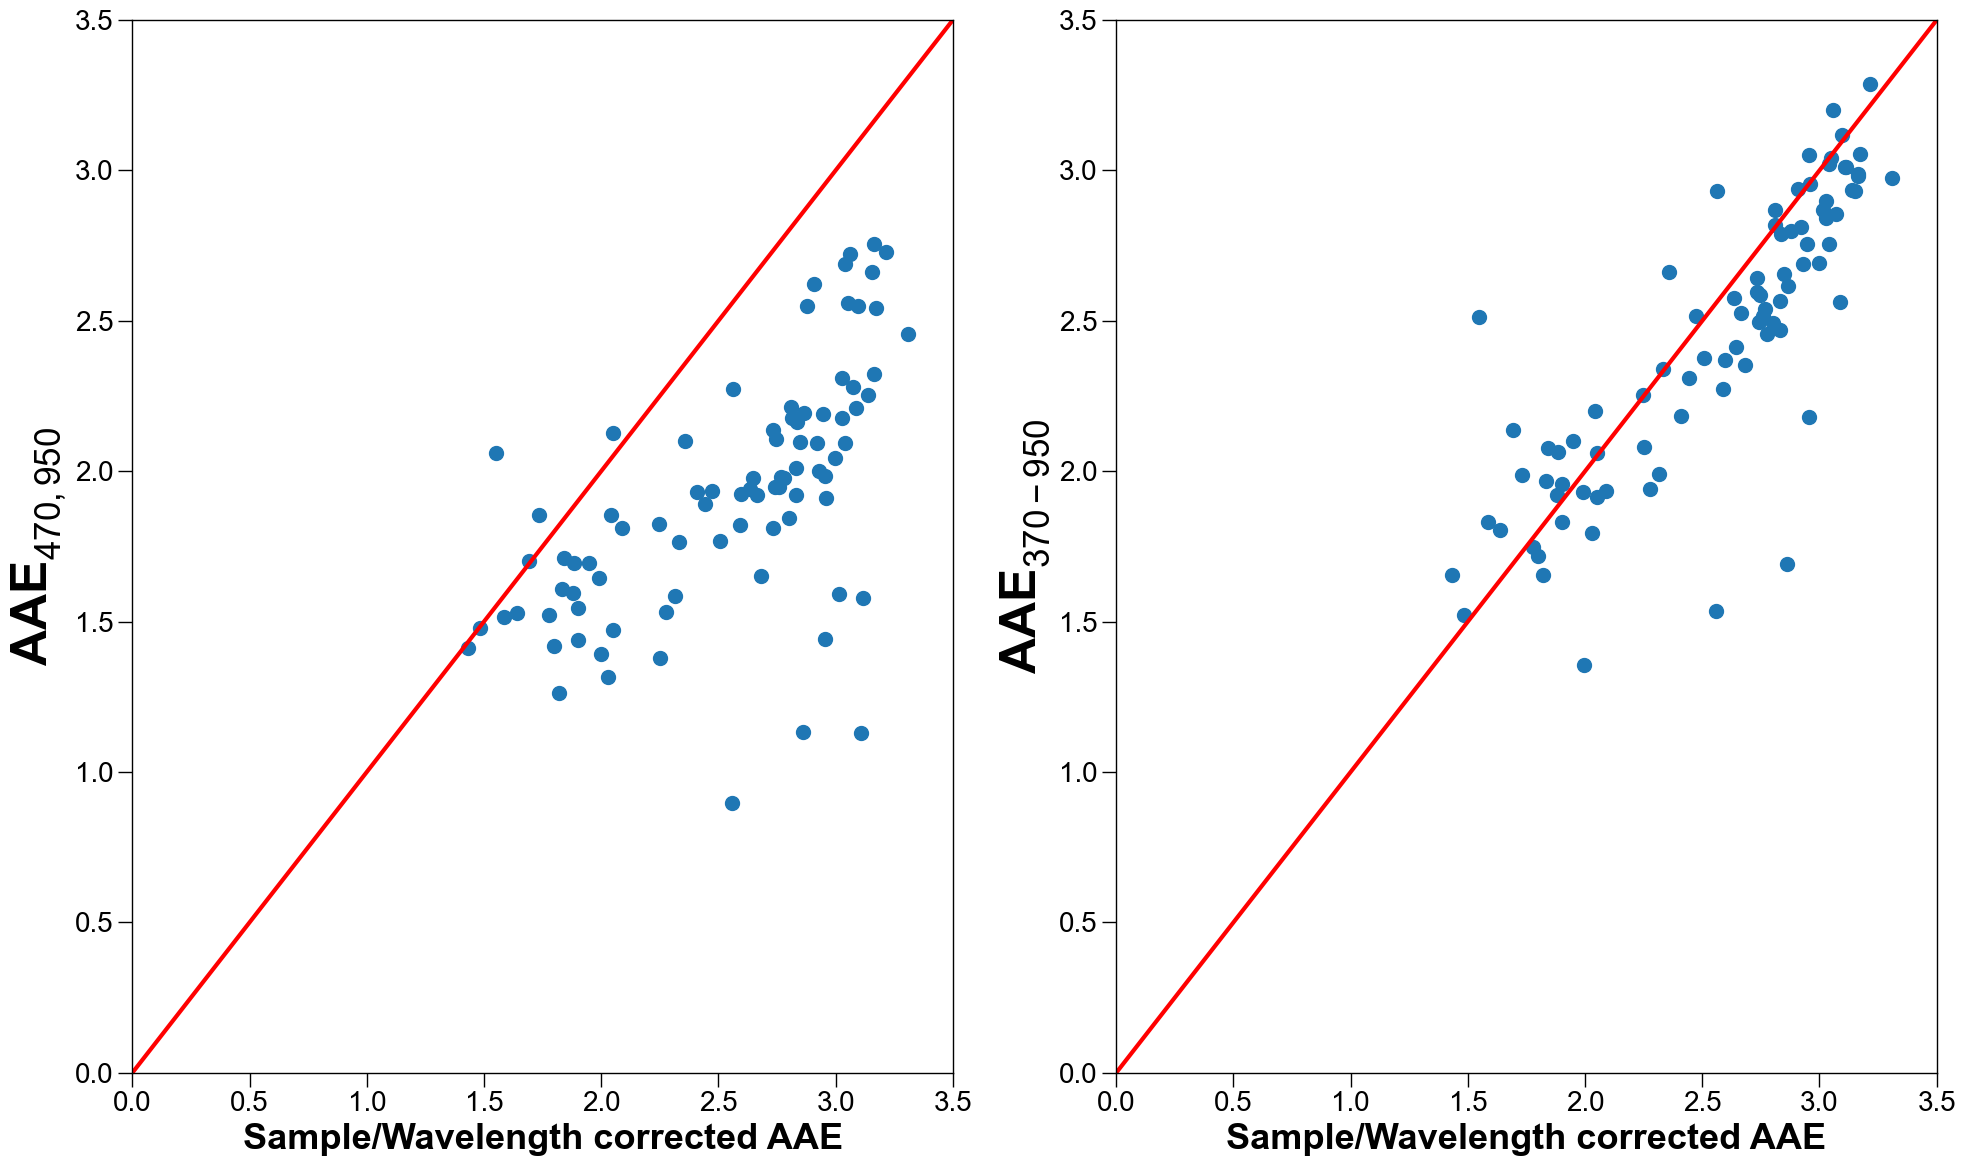

In [51]:
fig,ax = plt.subplots(1,2,sharex=True)

ax[0].plot(dfAAE.AAE_swN,dfAAE.AAE_2pt,'o',ms=10)
ax[0].set_ylabel('AAE$_{470,950}$',fontsize=36,fontweight='bold')


ax[1].plot(dfAAE.AAE_swN,dfAAE.AAE_7pt,'o',ms=10)
ax[1].set_ylabel('AAE$_{370-950}$',fontsize=36,fontweight='bold')


for i in range(2):
    ax[i].set_ylim([0,3.5])
    ax[i].set_xlim([0,3.5])
    ax[i].plot([0,4],[0,4],'-r')
    ax[i].set_xlabel('Sample/Wavelength corrected AAE',fontsize=26,fontweight='bold')

fig.tight_layout()
fig.savefig('AAE_compare_AE33corrected_vs_S&Wcorrected.png')